In [9]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import joblib
from lib.loader import FolderExtractor, Segment
from scipy.signal import savgol_filter

In [3]:
# ==== Parametry ====
HDF_PATH = "data"
DATASET_PATH = "waves/"
SIGNAL_NAME = "icp"
MAX_SAMPLES = 36000
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 4
EPOCHS = 20
BETA = 1e-3  # KL váha
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [4]:
class CreathonSegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - np.nanmean(data)) / (np.nanstd(data) + 1e-8)

            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good
    extractor.load_data(segments)

    return CreathonSegmentSequence(segments, window_size, batch_size)


In [5]:
# ==== Sampling layer ====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ==== Encoder ====
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# ==== Decoder ====
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

# ==== VAE ====
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
print("sekvence")
# ==== Trénování ====
sequence = load_sequence_from_folder(
    folder_path=HDF_PATH,
    signal_name=SIGNAL_NAME,
    use_anomalous=False,  # nebo True pokud chceš i anomální data
    window_size=500,
    batch_size=64
)
print("sekvence done")
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
print("enc a dec done")
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))
vae.fit(sequence, epochs=EPOCHS)

# ==== Uložení modelu ====
encoder.save(os.path.join(MODEL_DIR, "vae_encoder_hour.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_hour.keras"))

sekvence


NameError: name 'load_sequence_from_folder' is not defined

In [ ]:
def plot_generation(n_samples=3):
    random_latents = tf.random.normal((n_samples, LATENT_DIM))
    generated = vae.decoder(random_latents).numpy()
    
    # Inverzní transformace
    generated = generated * sequence.data_std + sequence.data_mean

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.plot(generated[i].squeeze())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()
def plot_reconstruction():
    X, _ = sequence[0]
    recon = vae.decoder(vae.encoder(X)[2]).numpy()

    # Inverzní transformace
    recon = recon * sequence.data_std + sequence.data_mean
    X = X * sequence.data_std + sequence.data_mean

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.plot(X[i].squeeze(), label="Original")
        plt.legend()
        plt.subplot(3, 2, i * 2 + 2)
        plt.plot(recon[i].squeeze(), label="Reconstruction")
        plt.legend()
    plt.tight_layout()
    plt.show()


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import Sequence
from lib.loader import FolderExtractor, SingleFileExtractor

# ==== Parametry ====
HDF_PATH = "data"
SIGNAL_NAME = "art"
WINDOW_SIZE = 500
BATCH_SIZE = 64
LATENT_DIM = 4
EPOCHS = 10
BETA = 1e-3
MODEL_DIR = "models"
MAX_SAMPLES = 36000
os.makedirs(MODEL_DIR, exist_ok=True)

# ==== Sekvencer ====
class CreathonSegmentSequence(Sequence):
    def __init__(self, segments, window_size=500, batch_size=64, normalize=True):
        self.window_size = window_size
        self.batch_size = batch_size
        self.normalize = normalize
        self.windows = []
        self.data_mean = None
        self.data_std = None

        all_data = np.concatenate([seg.data for seg in segments if seg.data is not None and len(seg.data) >= window_size])
        self.data_mean = np.nanmean(all_data)
        self.data_std = np.nanstd(all_data) + 1e-8

        for seg in segments:
            if seg.data is None or len(seg.data) < window_size:
                continue
            data = seg.data
            if normalize:
                data = (data - self.data_mean) / self.data_std
            for i in range(len(data) - window_size + 1):
                window = data[i:i + window_size]
                if np.isnan(window).any():
                    continue
                self.windows.append(window)

        self.windows = np.array(self.windows)[..., np.newaxis]

    def __len__(self):
        return len(self.windows) // self.batch_size

    def __getitem__(self, idx):
        batch = self.windows[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch, batch

# ==== Pomocné funkce ====
def get_file_paths(folder_path):
    folder_extractor = FolderExtractor(folder_path)
    return [e._hdf5_file_path for e in folder_extractor._extractors]

def load_sequence_from_single_file(file_path, annotations_path, signal_name="icp",
                                   window_size=500, batch_size=64, use_anomalous=False):
    extractor = SingleFileExtractor(file_path)
    extractor.auto_annotate(annotations_path)

    good, anom = extractor.extract(signal_name)
    segments = good + anom if use_anomalous else good

    # Omez segmenty na ty s omezeným počtem vzorků (MAX_SAMPLES)
    limited_segments = []
    total_samples = 0
    for seg in segments:
        if seg.data is None:
            continue
        if total_samples >= MAX_SAMPLES:
            break
        seg_length = len(seg.data)
        if total_samples + seg_length > MAX_SAMPLES:
            seg.data = seg.data[:MAX_SAMPLES - total_samples]  # zkrátit
        limited_segments.append(seg)
        total_samples += len(seg.data)

    extractor.load_data(limited_segments)
    return CreathonSegmentSequence(limited_segments, window_size, batch_size)

# ==== Sampling layer ====
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ==== Encoder ====
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(WINDOW_SIZE, 1))
    x = layers.Conv1D(16, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    z_mean = layers.Dense(latent_dim)(x)
    z_log_var = layers.Dense(latent_dim)(x)
    z = Sampling()([z_mean, z_log_var])
    return Model(inputs, [z_mean, z_log_var, z], name="encoder")

# ==== Decoder ====
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(500, activation="relu")(inputs)
    x = layers.Reshape((500, 1))(x)
    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(32, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(16, 3, padding="same", activation="relu")(x)
    x = layers.Conv1D(1, 3, padding="same", activation="linear")(x)
    return Model(inputs, x, name="decoder")

# ==== VAE ====
class VAE(Model):
    def __init__(self, encoder, decoder, beta=1e-3):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.recon_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    def compile(self, optimizer):
        super().compile()
        self.optimizer = optimizer

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            recon_loss = tf.reduce_mean(tf.square(data - reconstruction))
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = recon_loss + self.beta * kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.recon_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "recon_loss": self.recon_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# ==== Trénování ====
encoder = build_encoder(LATENT_DIM)
decoder = build_decoder(LATENT_DIM)
vae = VAE(encoder, decoder, beta=BETA)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

last_sequence = None

all_files = get_file_paths(HDF_PATH)
if all_files:
    file_path = all_files[0]
    print(f"Trénuji na prvním souboru: {os.path.basename(file_path)}")
    sequence = load_sequence_from_single_file(
        file_path=file_path,
        annotations_path=HDF_PATH,
        signal_name=SIGNAL_NAME,
        window_size=WINDOW_SIZE,
        batch_size=BATCH_SIZE,
        use_anomalous=False
    )
    if len(sequence) > 0:
        vae.fit(sequence, epochs=EPOCHS)
        last_sequence = sequence

encoder.save(os.path.join(MODEL_DIR, "vae_encoder_hour.keras"))
decoder.save(os.path.join(MODEL_DIR, "vae_decoder_hour.keras"))

# ==== Vizualizace ====
def plot_generation(n_samples=3):
    random_latents = tf.random.normal((n_samples, LATENT_DIM))
    generated = vae.decoder(random_latents).numpy()
    if last_sequence:
        generated = generated * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 2))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.plot(generated[i].squeeze())
        plt.title(f"Sample {i+1}")
    plt.tight_layout()
    plt.show()

def plot_reconstruction():
    if not last_sequence:
        print("Nebyla nalezena žádná trénovací sekvence.")
        return
    X, _ = last_sequence[0]
    recon = vae.decoder(vae.encoder(X)[2]).numpy()
    X = X * last_sequence.data_std + last_sequence.data_mean
    recon = recon * last_sequence.data_std + last_sequence.data_mean

    plt.figure(figsize=(10, 4))
    for i in range(3):
        plt.subplot(3, 2, i * 2 + 1)
        plt.plot(X[i].squeeze(), label="Original")
        plt.legend()
        plt.subplot(3, 2, i * 2 + 2)
        plt.plot(recon[i].squeeze(), label="Reconstruction")
        plt.legend()
    plt.tight_layout()
    plt.show()


Trénuji na prvním souboru: TBI_001_v2_1_2_20.hdf5
Epoch 1/10


c:\Development\Hackithon2025\Hackathon-2025\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2818/2818 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - kl_loss: 6.3766 - loss: 0.1520 - recon_loss: 0.1457
Epoch 2/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 4.2125 - loss: 0.0236 - recon_loss: 0.0193
Epoch 3/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - kl_loss: 3.9877 - loss: 0.0219 - recon_loss: 0.0180
Epoch 4/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.9105 - loss: 0.0200 - recon_loss: 0.0161
Epoch 5/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - kl_loss: 3.9001 - loss: 0.0193 - recon_loss: 0.0154
Epoch 6/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - kl_loss: 3.8999 - loss: 0.0190 - recon_loss: 0.0151
Epoch 7/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.8969 - loss: 0.0178 - recon_loss: 0.0139
Epoch 8/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.9000 - loss: 0.0178 - recon_loss: 0.0139
Epoch 9/10
2818/2818 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - kl_loss: 3.8947 - loss: 0.0167 - recon_loss: 0.0128
Epoch 10/10
2818/2818

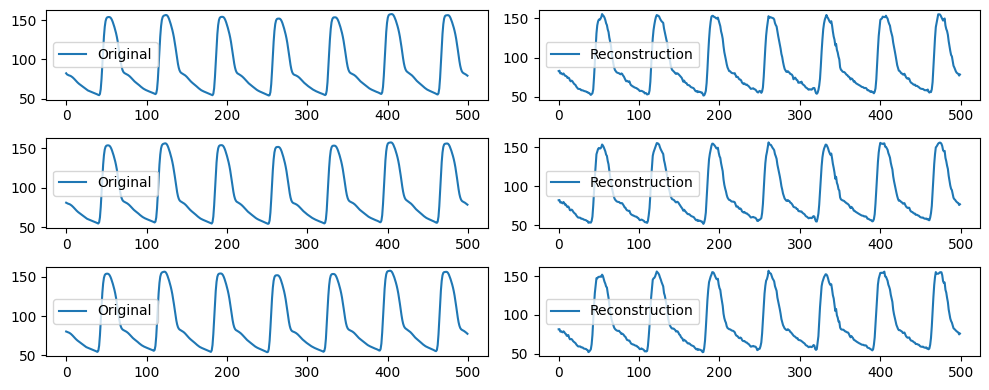

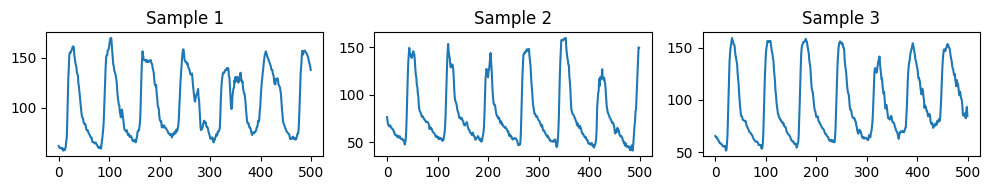

In [18]:
plot_reconstruction()
plot_generation(3)

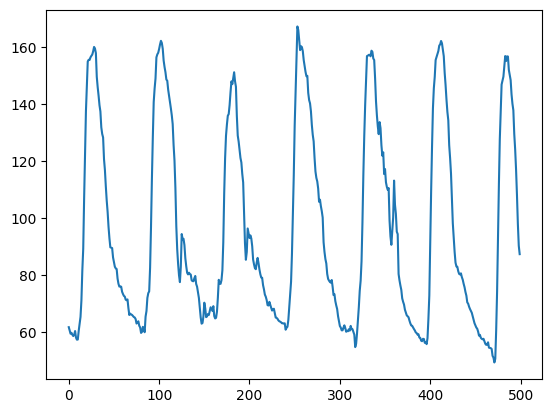

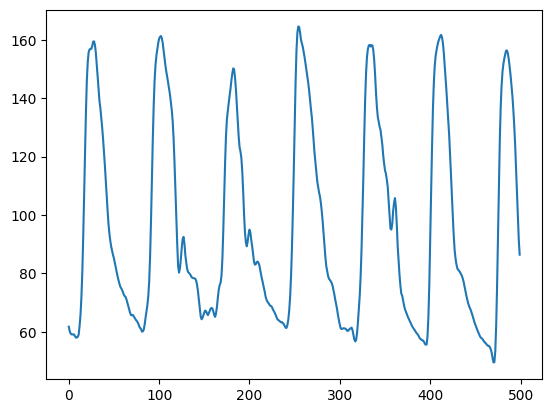

In [19]:
random_latents = tf.random.normal((3, LATENT_DIM))
generated = vae.decoder(random_latents).numpy()
generated = generated * last_sequence.data_std + last_sequence.data_mean

plt.plot(generated[0].squeeze())
plt.show()
plt.plot(savgol_filter(generated[0].squeeze(), 9, 3))
plt.show()